### 📓 PPE-Vision 360 — Detection Model Training (YOLOv8)
**Objective:**


Train an Object Detection model using YOLOv8 to identify whether workers are wearing required PPE items (Helmet, Vest, Gloves, Boots) from images.

Steps Covered in This Notebook:

1. Install required libraries (Ultralytics YOLOv8, Roboflow)

2. Load PPE Detection Dataset from Roboflow

3. Configure YOLOv8 data.yaml file

4. Train YOLOv8 Detection Model (starting with yolov8n.pt)

5. Evaluate Model Performance (mAP, IoU)

6. Export the trained model for deployment

**Environment:** Google Colab (Free GPU)

#### 1. Install required libraries (Ultralytics YOLOv8, Roboflow)

In [1]:
!pip install ultralytics roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 

#### Load PPE Detection Dataset from Roboflow

In [2]:
from google.colab import drive
import json

# Mount Google Drive
drive.mount('/content/drive')

# Load the API key from config.json
with open('/content/drive/MyDrive/PPE-Vision/config.json') as config_file:
    config = json.load(config_file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

from roboflow import Roboflow
rf = Roboflow(api_key=config['ROBOFLOW_API_KEY'])
project = rf.workspace("pram").project("ppe-detection-z3v2w")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PPE-Detection-2 in yolov8:: 100%|██████████| 6012/6012 [00:01<00:00, 3952.12it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Stored in Mydrive**

In [10]:
!mkdir -p /content/drive/MyDrive/PPE-Vision/datasets/detection/
!cp -r "/content/PPE-Detection-2" /content/drive/MyDrive/PPE-Vision/datasets/detection

In [5]:
!ls /content/drive/MyDrive/PPE-Vision/datasets/detection/


ppe-11	PPE-Detection-2


#### 4. Visualising the `train_labels`, `train_image`, and `data.yaml

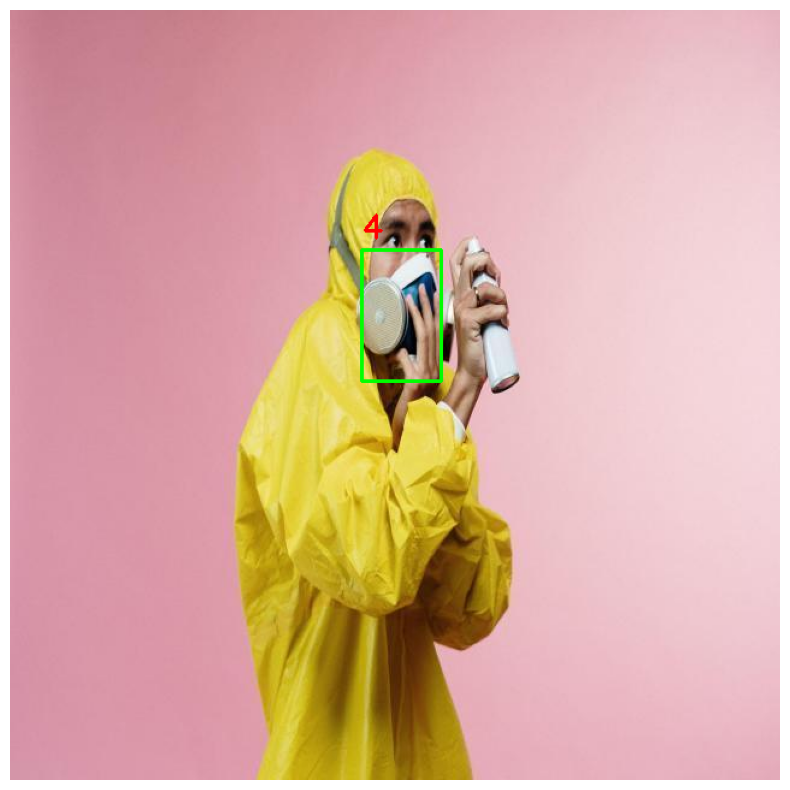

In [6]:
import cv2
import matplotlib.pyplot as plt
import random
import os

# Set paths
images_dir = '/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/train/images'
labels_dir = '/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/train/labels'

# Pick a random image
random_image = random.choice(os.listdir(images_dir))
image_path = os.path.join(images_dir, random_image)

# Corresponding label file
label_path = os.path.join(labels_dir, random_image.replace('.jpg', '.txt').replace('.png', '.txt'))

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read YOLOv8 label file
h, w, _ = image.shape
with open(label_path, 'r') as f:
    lines = f.readlines()

# Draw bounding boxes
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    # Convert YOLO normalized coordinates to absolute pixel values
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)
    # Draw rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Draw class id
    cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Show image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


In [7]:
import os

# Pick a random label file from train/labels
labels_dir = '/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/train/labels'
random_label_file = random.choice(os.listdir(labels_dir))
label_path = os.path.join(labels_dir, random_label_file)

# Read label file
print(f"Label File: {random_label_file}\n")
with open(label_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        class_id, x_center, y_center, width, height = line.strip().split()
        print(f"Class ID: {class_id} | x_center: {x_center} | y_center: {y_center} | width: {width} | height: {height}")


Label File: Video1_35_jpg.rf.9c5c91c97e17b6a653a4c843e91c19d3.txt

Class ID: 5 | x_center: 0.53203125 | y_center: 0.340625 | width: 0.2390625 | height: 0.225
Class ID: 4 | x_center: 0.53828125 | y_center: 0.20078125 | width: 0.1109375 | height: 0.0640625
Class ID: 2 | x_center: 0.48671875 | y_center: 0.6609375 | width: 0.1171875 | height: 0.121875
Class ID: 2 | x_center: 0.59921875 | y_center: 0.63359375 | width: 0.1453125 | height: 0.1109375
Class ID: 3 | x_center: 0.46796875 | y_center: 0.48828125 | width: 0.0734375 | height: 0.0546875
Class ID: 3 | x_center: 0.659375 | y_center: 0.4546875 | width: 0.040625 | height: 0.059375
Class ID: 0 | x_center: 0.5140625 | y_center: 0.14375 | width: 0.146875 | height: 0.065625
Class ID: 1 | x_center: 0.52578125 | y_center: 0.4171875 | width: 0.3078125 | height: 0.609375


In [8]:
import yaml

# Load data.yaml
yaml_path = '/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/data.yaml'
with open(yaml_path, 'r') as stream:
    data_yaml = yaml.safe_load(stream)

# Print Class Labels
print("Class Labels:")
for idx, name in enumerate(data_yaml['names']):
    print(f"Class ID {idx} → {name}")


Class Labels:
Class ID 0 → Hardhat
Class ID 1 → Person
Class ID 2 → Safety_Boots
Class ID 3 → Safety_Gloves
Class ID 4 → Safety_Mask
Class ID 5 → Safety_Vest


#### 5. Train YOLOv8 Detection Model (starting with yolov8n.pt)

In [9]:
from ultralytics import YOLO

# Load pre-trained YOLOv8 nano model (small, fast for experimentation)
model = YOLO('yolov8n.pt')

# Train the model on your dataset
model.train(
    data='/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/data.yaml',
    epochs=20,              # Start with 20 epochs
    imgsz=640,               # Image size
    batch=16,                # Adjust batch size if memory issues
    name='ppe_detection_model'  # Run name for saving results
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 96.5MB/s]


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_detection_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

100%|██████████| 755k/755k [00:00<00:00, 20.4MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,018 parameters, 3,012,002 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 83.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.7±0.3 ms, read: 4.5±9.6 MB/s, size: 48.6 KB)


train: Scanning /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/train/labels... 2099 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2100/2100 [14:41<00:00,  2.38it/s]

train: /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/train/images/2_0_40939043_jpg.rf.66ebae4db1bbf6123f55fa575206ac26.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/train/images/2_0_40939043_jpg.rf.66ebae4db1bbf6123f55fa575206ac26.jpg'


train: New cache created: /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.2±0.1 MB/s, size: 56.2 KB)


val: Scanning /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/valid/labels... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [04:12<00:00,  2.38it/s]


val: New cache created: /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5, len(boxes) = 2292. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/ppe_detection_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/ppe_detection_model
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.13G      1.195      2.158      1.289         17        640: 100%|██████████| 132/132 [00:46<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.22it/s]

                   all        600       2292      0.789      0.732      0.788       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.61G      1.146       1.32      1.236         18        640: 100%|██████████| 132/132 [00:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.15it/s]

                   all        600       2292      0.845      0.818      0.865      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.62G      1.139      1.214      1.228         34        640: 100%|██████████| 132/132 [00:43<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.82it/s]

                   all        600       2292      0.855       0.78      0.843      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.64G      1.122      1.134      1.236         24        640: 100%|██████████| 132/132 [00:42<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.73it/s]


                   all        600       2292      0.823      0.776      0.855      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.66G      1.095      1.055      1.213          6        640: 100%|██████████| 132/132 [00:41<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.22it/s]

                   all        600       2292      0.839      0.841      0.888      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.68G      1.049     0.9636      1.189         19        640: 100%|██████████| 132/132 [00:42<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]


                   all        600       2292      0.869      0.855      0.897      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.69G      1.044     0.9152       1.19         11        640: 100%|██████████| 132/132 [00:41<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.10it/s]

                   all        600       2292      0.882      0.863      0.905      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.71G      1.028     0.8823      1.175         19        640: 100%|██████████| 132/132 [00:42<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.62it/s]

                   all        600       2292      0.896      0.878      0.915      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.73G      1.012     0.8329      1.164         21        640: 100%|██████████| 132/132 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.16it/s]

                   all        600       2292      0.889      0.866      0.908      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.75G     0.9907     0.8002      1.147         10        640: 100%|██████████| 132/132 [00:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.78it/s]

                   all        600       2292      0.889      0.863      0.911      0.657


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.76G      1.019     0.7771      1.203          5        640: 100%|██████████| 132/132 [00:41<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]

                   all        600       2292      0.903      0.879      0.922       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.78G      1.006      0.727      1.194         14        640: 100%|██████████| 132/132 [00:40<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]

                   all        600       2292      0.912      0.884      0.928      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.8G     0.9778     0.6874      1.168         16        640: 100%|██████████| 132/132 [00:40<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.63it/s]

                   all        600       2292      0.919      0.871       0.93      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.81G     0.9469     0.6537      1.156          6        640: 100%|██████████| 132/132 [00:40<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


                   all        600       2292      0.906        0.9      0.936      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.83G     0.9408     0.6366      1.147         16        640: 100%|██████████| 132/132 [00:40<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]

                   all        600       2292       0.91        0.9      0.934      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.85G      0.919     0.6132       1.13         10        640: 100%|██████████| 132/132 [00:39<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]

                   all        600       2292       0.92      0.887       0.94      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.86G     0.9096     0.6046      1.127          6        640: 100%|██████████| 132/132 [00:39<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]

                   all        600       2292       0.92      0.892      0.941      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.88G     0.8942     0.5817      1.123         18        640: 100%|██████████| 132/132 [00:39<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.05it/s]

                   all        600       2292      0.911      0.899      0.944      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.9G     0.8784     0.5617      1.109         18        640: 100%|██████████| 132/132 [00:39<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.61it/s]


                   all        600       2292      0.914      0.906      0.946       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.91G     0.8622     0.5532      1.093          4        640: 100%|██████████| 132/132 [00:40<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]

                   all        600       2292      0.918      0.904      0.948      0.718



20 epochs completed in 0.270 hours.
Optimizer stripped from runs/detect/ppe_detection_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/ppe_detection_model/weights/best.pt, 6.2MB

Validating runs/detect/ppe_detection_model/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


                   all        600       2292      0.919      0.904      0.948      0.718
               Hardhat        357        383      0.979      0.961      0.983      0.853
                Person        269        323      0.952      0.929      0.983      0.836
          Safety_Boots        221        430      0.885      0.893      0.909      0.576
         Safety_Gloves        314        578      0.912      0.851      0.925      0.692
           Safety_Mask        253        285      0.877      0.852      0.924      0.558
           Safety_Vest        251        293      0.907      0.936      0.963      0.791
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/ppe_detection_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x788bc5809310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

#### 6. Save the model in MyDrive


In [11]:

# Save the best model to Drive
!cp /content/runs/detect/ppe_detection_model/weights/best.pt /content/drive/MyDrive/PPE-Vision/models/ppe_detection_best.pt


#### 7. Evaluate Model Performance (mAP, IoU)

In [15]:
from ultralytics import YOLO

# Load the trained model from Drive
model = YOLO('/content/drive/MyDrive/PPE-Vision/models/ppe_detection_best.pt')

# Run evaluation on the validation set
metrics = model.val(data='/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/data.yaml')

# Print key metrics
print(f"mAP50: {metrics.box.map50:.3f}")
print(f"mAP50-95: {metrics.box.map:.3f}")
print(f"Mean Precision: {metrics.box.mp:.3f}")
print(f"Mean Recall: {metrics.box.mr:.3f}")


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 20.8±9.4 MB/s, size: 37.2 KB)


val: Scanning /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/valid/labels.cache... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5, len(boxes) = 2292. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  3.99it/s]


                   all        600       2292      0.919      0.904      0.948      0.718
               Hardhat        357        383      0.979      0.961      0.983      0.853
                Person        269        323      0.952      0.929      0.983      0.836
          Safety_Boots        221        430      0.884      0.893      0.909      0.575
         Safety_Gloves        314        578      0.913      0.851      0.925      0.693
           Safety_Mask        253        285      0.877      0.852      0.924       0.56
           Safety_Vest        251        293      0.907      0.936      0.963      0.793
Speed: 1.2ms preprocess, 4.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val4
mAP50: 0.948
mAP50-95: 0.718
Mean Precision: 0.919
Mean Recall: 0.904


#### 8. Visualise Model on Precision-Recall barchat

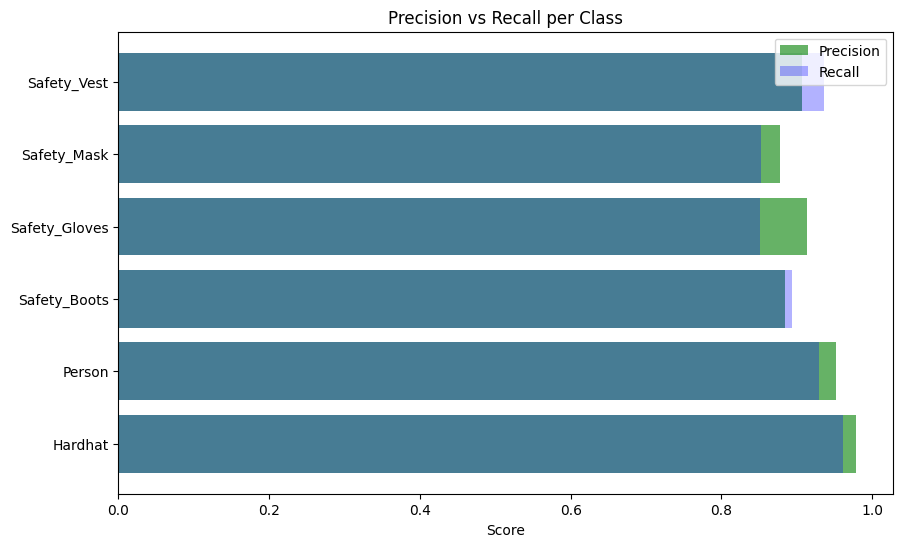

In [16]:
import matplotlib.pyplot as plt

# Example Precision and Recall values per class (from your evaluation)
class_names = ['Hardhat', 'Person', 'Safety_Boots', 'Safety_Gloves', 'Safety_Mask', 'Safety_Vest']
precision_values = [0.979, 0.952, 0.884, 0.913, 0.877, 0.907]
recall_values = [0.961, 0.929, 0.893, 0.851, 0.852, 0.936]

# Plot Precision-Recall per class
plt.figure(figsize=(10,6))
plt.barh(class_names, precision_values, color='green', alpha=0.6, label='Precision')
plt.barh(class_names, recall_values, color='blue', alpha=0.3, label='Recall')
plt.xlabel('Score')
plt.title('Precision vs Recall per Class')
plt.legend()
plt.show()


#### 9. Load model for Prediction

In [2]:
from ultralytics import YOLO

# Load the trained PPE Detection model
model = YOLO('/content/drive/MyDrive/PPE-Vision/models/ppe_detection_best.pt')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
result = model.predict(
    source='/content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/test/images',
    conf=0.5,
    save=True,
    line_width=3,
    project='runs/detect',
    name='ppe_inference_custom'
)



image 1/300 /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/test/images/00004_jpg.rf.4cfced324a0e3790b0a0e645c1147143.jpg: 640x640 1 Person, 1 Safety_Vest, 7.5ms
image 2/300 /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/test/images/00035_jpg.rf.e98f9e76eca3557945fbf1543fcefaa9.jpg: 640x640 1 Person, 1 Safety_Vest, 9.9ms
image 3/300 /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/test/images/00090_jpg.rf.2893c11f629dafe94b2443bebdfa94f5.jpg: 640x640 1 Person, 3 Safety_Vests, 7.5ms
image 4/300 /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/test/images/00095_jpg.rf.e753cfd4a4d5ed13e23b216d7bf33162.jpg: 640x640 1 Person, 4 Safety_Bootss, 3 Safety_Vests, 39.1ms
image 5/300 /content/drive/MyDrive/PPE-Vision/datasets/detection/PPE-Detection-2/test/images/00178_jpg.rf.d684e8604ad85da87644328adf4d5f66.jpg: 640x640 1 Hardhat, 2 Persons, 1 Safety_Vest, 19.2ms
image 6/300 /content/drive/MyDrive/PPE-Vision/datas

In [4]:
!ls /content/runs/detect/


ppe_inference_custom


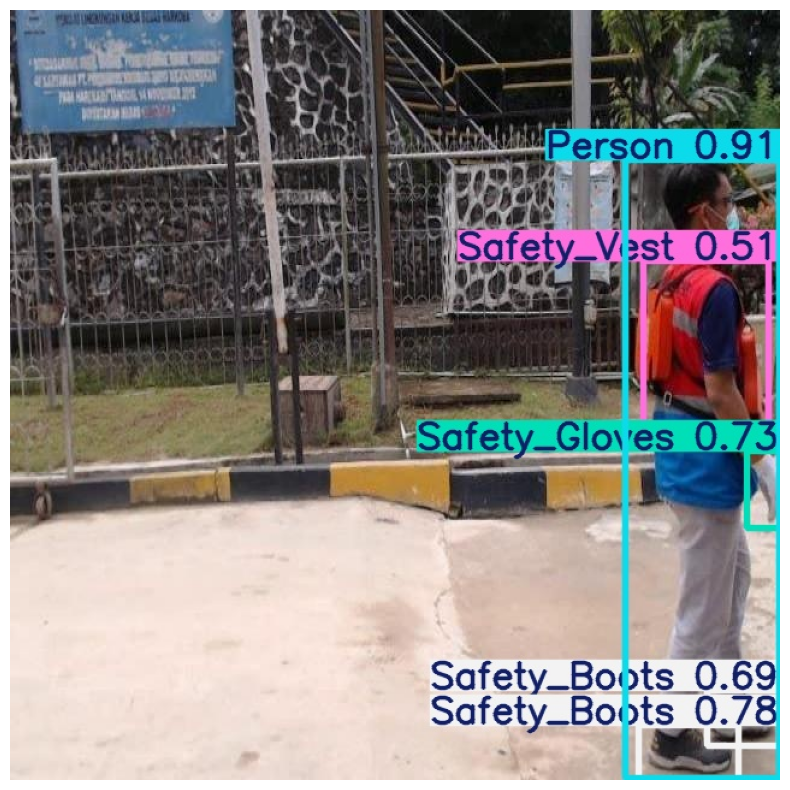

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load the first saved image
pred_dir = '/content/runs/detect/ppe_inference_custom'
pred_images = os.listdir(pred_dir)

# Display one image
img_path = os.path.join(pred_dir, pred_images[0])
img = Image.open(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()


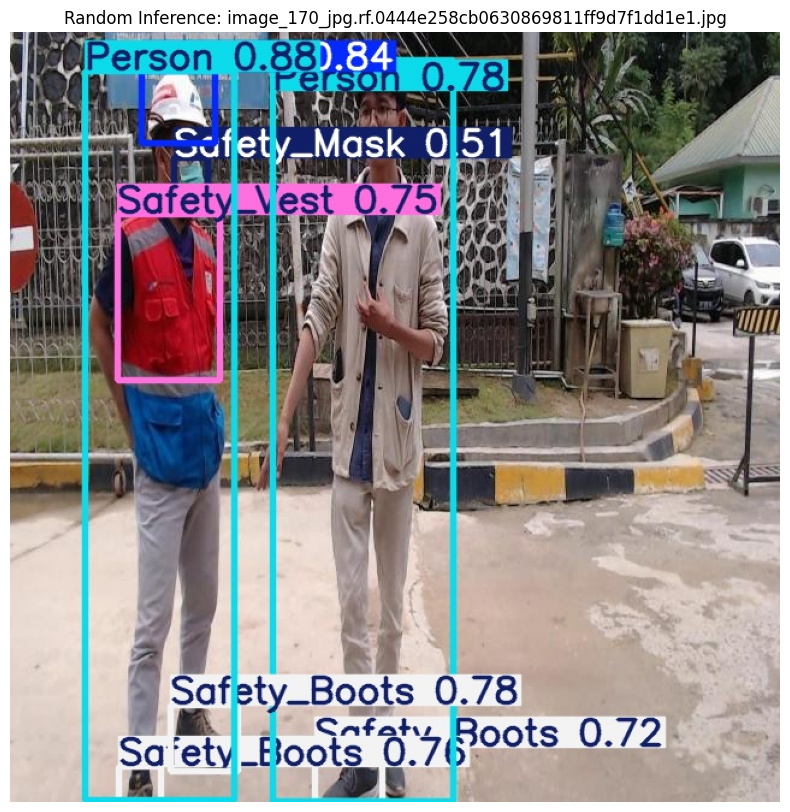

In [7]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path to your inference results folder
pred_dir = '/content/runs/detect/ppe_inference_custom/'  # Update if folder name is different

# List all prediction images
pred_images = os.listdir(pred_dir)

# Ensure there are images
if pred_images:
    # Pick a random image
    random_image = random.choice(pred_images)
    img_path = os.path.join(pred_dir, random_image)

    # Open and display the image
    img = Image.open(img_path)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Random Inference: {random_image}")
    plt.show()
else:
    print("No prediction images found.")


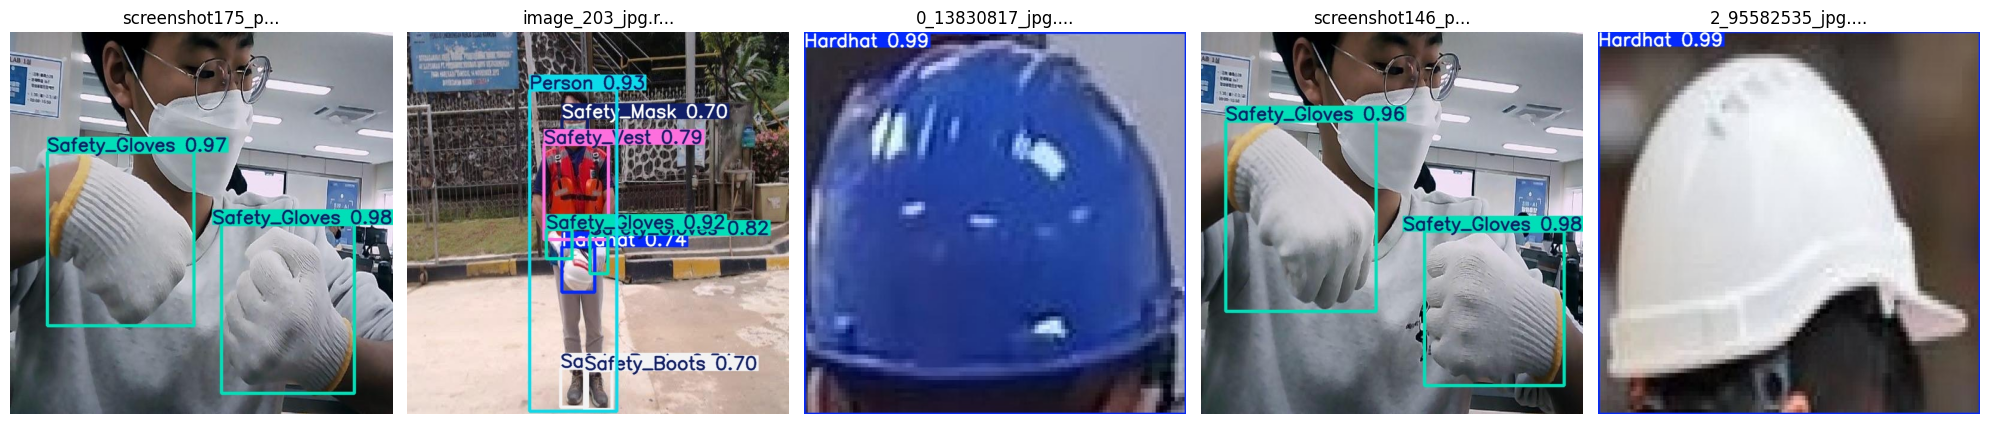

In [8]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path to your inference results folder
pred_dir = '/content/runs/detect/ppe_inference_custom/'  # Change folder name if different

# List all predicted images
pred_images = os.listdir(pred_dir)

# Ensure there are images
if pred_images:
    # Randomly select 5 unique images
    random_images = random.sample(pred_images, min(5, len(pred_images)))

    # Plot them
    plt.figure(figsize=(20, 10))  # Adjust the size as needed

    for i, img_file in enumerate(random_images):
        img_path = os.path.join(pred_dir, img_file)
        img = Image.open(img_path)

        plt.subplot(1, 5, i+1)  # 1 row, 5 columns
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{img_file[:15]}...")  # Short title

    plt.tight_layout()
    plt.show()

else:
    print("No prediction images found.")
